## Предсказание законтрактованности путём агрегации данных о предыдущих поставках

Мы проведём сравнение двух методов:
1) Усреднение параметров поставок (таких как процент опоздания по поставкам и изменение качества)
2) Усреднение эмбеддингов предыдущих поставок, полученных через LSTM автоэнкодер

In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
import os
sys.path.append(os.path.abspath('..'))
from data.preprocessing import Preprocessor
from data.feature_generation import zpp4_agg_features, zpp4_embed_agg, spec_agg_features
from figures.plots import show_embeddings
from src.metrics import mapk

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""
Загрузка данных
"""

# таблица со спецификациями
spec = pd.read_csv('../data/processed_data/specs.csv')
spec['spec_date'] = pd.to_datetime(spec['spec_date'], format='%Y-%m-%d')
spec['delivery_period_end'] = pd.to_datetime(spec['delivery_period_end'], format='%Y-%m-%d')

# таблица с доставками
zpp4 = pd.read_csv('../data/processed_data/zpp4.csv')
zpp4['date'] = pd.to_datetime(zpp4['date'], format='%Y-%m-%d')
zpp4['spec_date'] = pd.to_datetime(zpp4['spec_date'], format='%Y-%m-%d')

In [4]:
"""
Генерация фичей
"""

# фичи аггрегации
spec = zpp4_agg_features(spec, zpp4)

# фичи эмбеддинги
spec = zpp4_embed_agg(spec)

# агрегация из прошлых спецификаций
spec = spec_agg_features(spec)

features = [['lateness', 'underweight', 'price_change'],
            [str(i) for i in range(16)],
            ['delivery_length', 'mean_delivery_length', 'delivery_length_diff', 'mean_volume', 'volume_diff', 'conversion']]

spec = spec.dropna()

# разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
        spec.drop('bids_contracted', axis=1),
        spec['bids_contracted'],
        test_size=0.2, random_state=42
)

In [4]:
"""
Предсказание законтрактованности (Простые агрегации)
"""

def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

print('Бустинг (Простые агрегации):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[0]], y_train)
estimate(model, X_test[features[0]], y_test)

Бустинг (Простые агрегации):
Accuracy: 0.7167785234899329
ROC AUC: 0.6969916077947941


In [5]:
"""
Предсказание законтрактованности (агрегация эмбеддингов)
"""

print('Бустинг (агрегация эмбеддингов):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[1]], y_train)
estimate(model, X_test[features[1]], y_test)

Бустинг (агрегация эмбеддингов):
Accuracy: 0.7449664429530202
ROC AUC: 0.763362729758349


In [14]:
def split_by_day(X, y, features, model):
    actual = []
    predicted = []
    
    days_indexes = X.groupby('spec_date').apply(lambda x: x.index)
    for day in days_indexes:
        actual.append(list(y.loc[day].values))
        predicted.append(list(model.predict(X[features].loc[day])))
    
    return actual, predicted

In [7]:
split_point = np.quantile(spec['spec_date'], 0.8)
train_spec = spec.loc[spec['spec_date'] < split_point]
test_spec = spec.loc[spec['spec_date'] >= split_point]

X_train = train_spec.drop('bids_contracted', axis=1)
y_train = train_spec['bids_contracted']

X_test = test_spec.drop('bids_contracted', axis=1)
y_test = test_spec['bids_contracted']

In [8]:
print('Бустинг (Простые агрегации):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[0]], y_train)
actual, predicted = split_by_day(X_test, y_test, features[0], model)
print(f'{mapk(actual, predicted)}')

Бустинг (Простые агрегации):


0.2955131090578852

In [9]:
print('Бустинг (агрегация эмбеддингов):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[1]], y_train)
actual, predicted = split_by_day(X_test, y_test, features[1], model)
print(f'{mapk(actual, predicted)}')

Бустинг (агрегация эмбеддингов):


0.29464621337755664

## Комбинирование переменных

In [10]:
"""
Предсказание законтрактованности (Простые агрегации + агрегации спецификаций)
"""

def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

print('Бустинг (Простые агрегации):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[0] + features[2]], y_train)
estimate(model, X_test[features[0] + features[2]], y_test)

Бустинг (Простые агрегации):
Accuracy: 0.7476510067114094
ROC AUC: 0.7976704123401768


In [11]:
"""
Предсказание законтрактованности (Простые агрегации + агрегации спецификаций)
"""

def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

print('Бустинг (агрегация эмбеддингов):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[1] + features[2]], y_train)
estimate(model, X_test[features[1] + features[2]], y_test)

Бустинг (Простые агрегации):
Accuracy: 0.7570469798657719
ROC AUC: 0.7956079212302246


In [15]:
print('Бустинг (Простые агрегации):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[0]], y_train)
actual, predicted = split_by_day(X_test, y_test, features[0] + features[2], model)
mapk(actual, predicted)

Бустинг (Простые агрегации):


0.48791371409674983

In [16]:
print('Бустинг (агрегация эмбеддингов):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features[1]], y_train)
actual, predicted = split_by_day(X_test, y_test, features[1] + features[2], model)
mapk(actual, predicted)

Бустинг (агрегация эмбеддингов):


0.5187334065570672

In [16]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
def sas_embeddings(vectors, labels=None):
    # reduce dimensions with TSNE
    trans_vectors = TSNE(
        n_components=2, learning_rate='auto', init='random',
        perplexity=40, random_state=22
    ).fit_transform(vectors)
    
    for label in np.unique(labels):
        indexes = np.where(labels == label)[0]
        plt.scatter(
            trans_vectors[indexes, 0],
            trans_vectors[indexes, 1],
            alpha=0.2, linewidths=0,
        )
    return

TypeError: scatter() got multiple values for argument 'alpha'

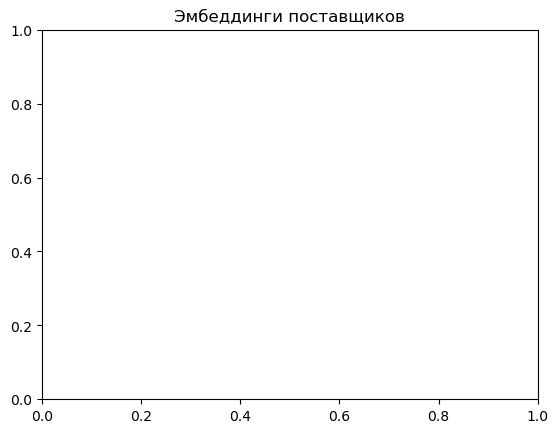

In [11]:
plt.title('Эмбеддинги поставщиков')
sas_embeddings(spec[features[1]], spec['bids_contracted'])
plt.legend()
# plt.savefig('../figures/contracted_embedings.jpg', bbox_inches='tight')

AttributeError: 'list' object has no attribute 'legend'

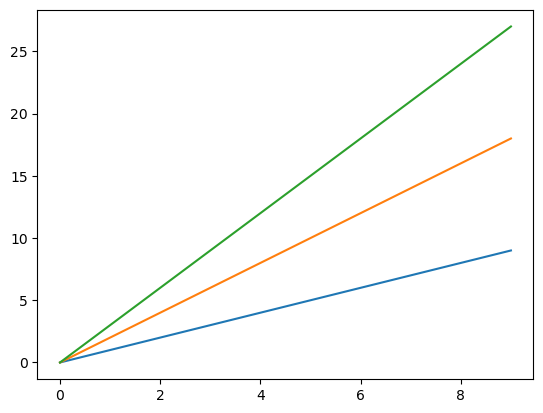

In [14]:
x = np.arange(10)
y = np.arange(10)
p = plt.plot(x,y, x,y*2, x,y*3)
p.legend()

In [15]:
p[0].get_color()

'#1f77b4'